In [3]:
import akshare as ak
import numpy as np
import pandas as pd
import datetime as dt
import time
import os 
from tqdm import tqdm
import alphalens
from scipy.stats import rankdata

In [4]:
class dataloader():
    def __init__(self):

        # 待选股列表
        self.slist = None
        self.slist_path ='slist.csv'

        #  历史成分股（不全）
        self.slist_hist = None

        # 股票信息
        self.sinfo = None
        self.sinfo_path = 'sinfo.csv'
        
        # 不考虑的股票
        self.filtered_slist = None

        # 股票数据 
        self.sdata = None
        self.sdata_path = 'sdata.csv'

        self.slist_used = None

    def get_slist(self,symbol='000300'):
        # 最新中正成分股（包含沪深300）
        if self.slist is not None:
            self.slist_used = self.slist.code.values
            return self.slist
        elif os.path.exists(self.slist_path):
            # local file exist
            self.slist = pd.read_csv(self.slist_path,encoding='gbk',dtype={'code':str})
            self.slist_used = self.slist.code.values
        else:
            # extract info
            self.slist = ak.index_stock_cons_csindex(symbol=symbol).iloc[:,[0,4,5]]
            self.slist.columns = ['date','code','name']
            self.slist.date = pd.to_datetime(self.slist.date)
            self.slist.to_csv(self.slist_path,index=False,encoding='gbk')
            self.slist_used = self.slist.code.values
    
    def get_hs300_hist(self):
        # see get_hs300.ipynb
        slist = pd.read_csv('hs300_stocks.csv')
        return slist

    def get_slist_info(self):
        # 获取股票数据信息
        if self.sinfo is not None:
            return self.sinfo
        elif os.path.exists(self.sinfo_path):
            self.sinfo = pd.read_csv(self.sinfo_path,encoding='gbk',dtype={'股票代码':str})
            self.sinfo['上市时间'] = pd.to_datetime(self.sinfo['上市时间'],format='%Y%m%d')
        else:
            self.sinfo = pd.DataFrame(columns=['总市值', '流通市值', '行业', '上市时间', '股票代码', '股票简称', '总股本', '流通股'])

            # count for sleep
            count = 0
            for i in self.slist.code.unique():
                self.sinfo.loc[len(self.sinfo)] = ak.stock_individual_info_em(symbol=i).value.values
                if count%20 ==0:
                    time.sleep(0.7)
            self.sinfo['上市时间'] = pd.to_datetime(self.sinfo['上市时间'],format='%Y%m%d')
            self.sinfo.to_csv(self.sinfo_path,index=False,encoding='gbk')

            return self.sinfo

    def filter_slist(self,date):
        # 过滤上市在date之后的股票
        if self.sinfo is None:
           _ = self.get_slist_info()

        self.filtered_slist = self.sinfo[self.sinfo['上市时间']>date].股票代码.sort_values().values
        self.slist_used = self.slist_used[~np.isin(self.slist_used,self.filtered_slist)]
        return self.filtered_slist

    def get_sdata(self,start="2021/01/01",end='2021/01/231',adjust='qfq'):
        # 从akshare获取股票数据
        start_date=pd.to_datetime(start).strftime('%Y%m%d')
        end_date=pd.to_datetime(end).strftime('%Y%m%d')
        if self.sdata:
            return self.sdata
        elif os.path.exists(self.sdata_path):
            self.sdata = pd.read_csv(self.sdata_path,dtype={'code':str})
            self.sdata.date = pd.to_datetime(self.sdata.date)
            self.sdata.set_index(['date','code'],inplace=True)
            return self.sdata
        else:
            self.sdata=pd.DataFrame(columns=['日期', '开盘', '收盘', '最高', '最低', '成交量', '成交额', '振幅', '涨跌幅', '涨跌额', '换手率','code'])

            # count for sleep
            count = 0
            if self.slist_used is None:
                self.slist_used = self.slist           
            for i in tqdm(self.slist_used):
                temp=ak.stock_zh_a_hist(symbol=i, period="daily", start_date=start_date, end_date=end_date, adjust=adjust)
                temp['code']=i
                self.sdata=self.sdata.append(temp,ignore_index=True)
                if count%20 ==0:
                    time.sleep(0.7)

            self.sdata.drop(['振幅', '涨跌幅', '涨跌额', '换手率'], axis=1 , inplace=True)
            self.sdata.columns = ['date','open','close','high','low','volume','amount','code']
            self.sdata.volume = self.sdata.volume*100
            self.sdata.date = pd.to_datetime(self.sdata.date)
            self.sdata.to_csv(self.sdata_path,index=False,encoding='gbk')
            
            self.sdata.set_index(['date','code'],inplace=True)
            
            return self.sdata

    def get_sdata_tdx(self,file_path,start="2021/01/01",end='2021/01/31'):
        # 通达信数据
        if self.sdata is not None:
            return self.sdata
        else:
            if self.slist_used is None:
                self.slist_used = self.slist
            self.sdata=pd.DataFrame()
            for i in tqdm(self.slist_used):
                temp = pd.read_csv(file_path+i+'.csv',header=None)
                temp['code'] = i
                self.sdata = self.sdata.append(temp)
            self.sdata.columns = ['date','open','high','low','close','volume','amount','code']
            self.sdata.date = pd.to_datetime(self.sdata.date)
            self.sdata = self.sdata[(self.sdata.date>pd.to_datetime(start))&(self.sdata.date<pd.to_datetime(end))].reset_index(drop=True)

            self.sdata.set_index(['date','code'],inplace=True)

            return self.sdata

    def clean_tdx(self,path):
        # 删除数据最后一行
        for i in os.listdir(path):
            temp = pd.read_csv(path+i,encoding='gbk',header=None)
            temp = temp.iloc[:-1,:]
            temp.to_csv(path+i,index=False,header=None)

    def add_factor(self,x,name):
        if name in self.sdata.columns:
            print('Name exist')
        else:
            self.sdata[name] = x
            self.factor.append(name)

    def first_n(self,x,n):
        return x[x.groupby(by='date').rank()<(n+1)]

    def first_n_todict(self,name,n):
        if name in self.factor:        
            self.trade[name] = self.first_n(self.sdata[name],n).reset_index(level=0).groupby('date').groups
            #return self.trade[name]

    def date_trade(self,name,date):
        return self.trade[name][pd.to_datetime(date)]


In [5]:
dl = dataloader()
_=dl.get_slist()
dl.filter_slist(pd.to_datetime('2014-01-01'))

array(['000166', '001289', '001979', '002709', '002714', '002736',
       '002791', '002812', '002821', '002841', '002916', '002920',
       '002938', '003816', '300408', '300413', '300433', '300450',
       '300454', '300496', '300498', '300529', '300595', '300601',
       '300628', '300661', '300750', '300751', '300759', '300760',
       '300763', '300782', '300866', '300896', '300919', '300957',
       '300979', '300999', '600025', '600905', '600918', '600919',
       '600926', '600941', '600958', '600989', '601021', '601066',
       '601138', '601155', '601211', '601225', '601229', '601236',
       '601319', '601658', '601698', '601728', '601816', '601825',
       '601838', '601865', '601868', '601878', '601881', '601916',
       '601966', '601985', '601995', '603019', '603087', '603160',
       '603185', '603195', '603259', '603260', '603288', '603290',
       '603369', '603392', '603486', '603501', '603659', '603799',
       '603806', '603833', '603882', '603899', '603986', '6054

In [6]:
dl.get_sdata_tdx('E:/s/tdx/',start="2018/01/01",end='2021/01/31')

100%|██████████| 197/197 [00:04<00:00, 49.21it/s]


,,open,high,low,close,volume,amount
date,code,,,,,,
2018-01-02,000001,12.44,13.02,12.41,12.79,208159200.0,2.856543e+09
2018-01-03,000001,12.82,12.95,12.29,12.42,296249792.0,4.006220e+09
2018-01-04,000001,12.41,12.46,12.22,12.34,185450896.0,2.454543e+09
2018-01-05,000001,12.30,12.44,12.24,12.39,121031200.0,1.603289e+09
2018-01-08,000001,12.34,12.38,11.95,12.05,215862000.0,2.806099e+09
...,...,...,...,...,...,...,...
2021-01-25,300274,98.75,113.37,97.56,102.25,81047212.0,8.559588e+09
2021-01-26,300274,98.75,100.03,94.12,95.33,86710593.0,8.400924e+09
2021-01-27,300274,97.64,104.25,92.26,104.25,72114934.0,7.084138e+09


# alpha

In [8]:
def sma(x,n):
    return x.groupby(by='code').apply(lambda x: x.rolling(n).mean())


def ts_sum(x,n):
    return x.groupby(by='code').apply(lambda x: x.rolling(n).sum())

def rank(x):
    return x.groupby(by='date').rank(pct=True)

def ts_rank(x,n):
    # keep multiindex
    return x.groupby('code').rolling(n).apply(lambda x: rankdata(x)[-1]).set_axis(x.index)

# def ts_rank(x,n):
#     # keep multiindex(alternative)
#     return x.groupby('code').apply(lambda x : x.rolling(n).apply(lambda x: rankdata(x)[-1]))

def stddev(x,n):
    return x.groupby(by='code').apply(lambda x: x.rolling(n).std())

def covariance(x,y,n):
    return pd.concat([x,y],axis=1).reset_index(level=1).groupby(by='code').rolling(n).cov().unstack().iloc[:,-2].reorder_levels(['date','code'])

def correlation(x,y,n):
    return pd.concat([x,y],axis=1).reset_index(level=1).groupby(by='code').rolling(n).corr().unstack().iloc[:,-2].reorder_levels(['date','code'])

def delta(x,n):
    return x-x.groupby('code').shift(n)

def adv(x,n):
    return x.volume.groupby('code').apply(lambda x: x.rolling(n).mean())

In [9]:
temp = dl.sdata[:50]
temp.head()

,,open,high,low,close,volume,amount
date,code,,,,,,
2018-01-02,000001,12.44,13.02,12.41,12.79,208159200.0,2.856543e+09
2018-01-03,000001,12.82,12.95,12.29,12.42,296249792.0,4.006220e+09
2018-01-04,000001,12.41,12.46,12.22,12.34,185450896.0,2.454543e+09
2018-01-05,000001,12.30,12.44,12.24,12.39,121031200.0,1.603289e+09
2018-01-08,000001,12.34,12.38,11.95,12.05,215862000.0,2.806099e+09


In [10]:
def alpha_6(data):
    return -1*correlation(data.open,data.volume,10)

In [11]:
def alpha_17(data):
    return -1*rank(ts_rank(data.close,10))*rank(delta(delta(data.close,1),1))*rank(ts_rank(data.volume/adv(data,20),5))

In [14]:
alpha_17(dl.sdata)

date        code  
2018-01-02  000001         NaN
2018-01-03  000001         NaN
2018-01-04  000001         NaN
2018-01-05  000001         NaN
2018-01-08  000001         NaN
                        ...   
2021-01-25  300274   -0.110043
2021-01-26  300274   -0.002965
2021-01-27  300274   -0.284574
2021-01-28  300274   -0.002244
2021-01-29  300274   -0.028378
Length: 145986, dtype: float64

In [7]:
# Avoid future function
factor = alpha_6().groupby(by='code').shift(1)
factor

date        code  
2018-01-02  000001         NaN
2018-01-03  000001         NaN
2018-01-04  000001         NaN
2018-01-05  000001         NaN
2018-01-08  000001         NaN
                        ...   
2021-01-25  603993   -0.881395
2021-01-26  603993   -0.785936
2021-01-27  603993   -0.505683
2021-01-28  603993   -0.034446
2021-01-29  603993   -0.135150
Name: alpha6, Length: 145986, dtype: float64

In [8]:
dl.sdata['factor']=factor

In [9]:
dl.sdata

,,open,high,low,close,volume,amount,factor
date,code,,,,,,,
2018-01-02,000001,12.44,13.02,12.41,12.79,208159200.0,2.856543e+09,NaN
2018-01-03,000001,12.82,12.95,12.29,12.42,296249792.0,4.006220e+09,NaN
2018-01-04,000001,12.41,12.46,12.22,12.34,185450896.0,2.454543e+09,NaN
2018-01-05,000001,12.30,12.44,12.24,12.39,121031200.0,1.603289e+09,NaN
2018-01-08,000001,12.34,12.38,11.95,12.05,215862000.0,2.806099e+09,NaN
...,...,...,...,...,...,...,...,...
2021-01-25,300274,98.75,113.37,97.56,102.25,81047212.0,8.559588e+09,-0.202411
2021-01-26,300274,98.75,100.03,94.12,95.33,86710593.0,8.400924e+09,-0.663228
2021-01-27,300274,97.64,104.25,92.26,104.25,72114934.0,7.084138e+09,-0.811752


In [10]:
def adjust_index(x):
    # The required format for alphalens.
    x.reset_index(inplace=True)
    x.index=pd.to_datetime(x.date)
    x.set_index([x.index,x.code],inplace=True)
    return x

In [11]:
adjust_index(dl.sdata)

,,date,code,open,high,low,close,volume,amount,factor
date,code,,,,,,,,,
2018-01-02,000001,2018-01-02,000001,12.44,13.02,12.41,12.79,208159200.0,2.856543e+09,NaN
2018-01-03,000001,2018-01-03,000001,12.82,12.95,12.29,12.42,296249792.0,4.006220e+09,NaN
2018-01-04,000001,2018-01-04,000001,12.41,12.46,12.22,12.34,185450896.0,2.454543e+09,NaN
2018-01-05,000001,2018-01-05,000001,12.30,12.44,12.24,12.39,121031200.0,1.603289e+09,NaN
2018-01-08,000001,2018-01-08,000001,12.34,12.38,11.95,12.05,215862000.0,2.806099e+09,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-01-25,300274,2021-01-25,300274,98.75,113.37,97.56,102.25,81047212.0,8.559588e+09,-0.202411
2021-01-26,300274,2021-01-26,300274,98.75,100.03,94.12,95.33,86710593.0,8.400924e+09,-0.663228
2021-01-27,300274,2021-01-27,300274,97.64,104.25,92.26,104.25,72114934.0,7.084138e+09,-0.811752


In [12]:
alpha_pri = dl.sdata.pivot(index='date',columns='code',values='open')
alpha_pri.index = pd.to_datetime(alpha_pri.index)

In [13]:
alpha_pri

code,000001,000002,000063,000066,000069,000100,000157,000301,000333,000338,...,601888,601898,601899,601901,601919,601939,601988,601989,601998,603993
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,12.44,26.26,35.78,6.97,7.10,3.31,3.15,4.76,48.74,6.60,...,39.46,5.03,4.05,6.81,4.38,6.08,3.01,5.98,4.91,6.57
2018-01-03,12.82,27.31,34.93,6.79,7.51,3.33,3.24,4.86,49.15,6.92,...,39.24,5.12,4.00,6.90,4.51,6.09,3.00,6.02,5.00,6.63
2018-01-04,12.41,27.57,35.67,6.80,7.57,3.41,3.22,4.84,48.61,6.83,...,41.06,5.10,3.95,7.09,4.51,6.15,3.03,6.10,5.08,6.65
2018-01-05,12.30,27.79,36.00,6.95,7.65,3.40,3.20,4.89,50.19,6.94,...,41.20,5.21,4.09,7.04,4.61,6.03,3.03,6.07,5.11,6.84
2018-01-08,12.34,29.92,35.30,6.84,8.10,3.35,3.26,4.87,50.29,6.77,...,41.19,5.29,3.97,7.04,4.69,6.09,3.01,6.07,5.15,6.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,21.31,27.03,34.46,17.82,6.35,9.55,11.14,14.96,97.70,18.46,...,285.51,3.87,10.52,8.67,10.75,5.83,2.75,4.21,4.54,6.46
2021-01-26,21.89,27.03,34.79,18.76,6.32,9.11,11.28,15.04,97.70,18.30,...,299.05,3.93,10.68,8.66,10.39,5.91,2.75,4.13,4.60,6.49
2021-01-27,21.90,27.46,33.56,17.16,6.24,9.19,10.84,15.07,93.79,18.21,...,296.60,3.88,10.47,8.85,9.97,5.96,2.75,4.10,4.64,6.20


In [14]:
ret = alphalens.utils.get_clean_factor_and_forward_returns(factor=dl.sdata.factor,prices=alpha_pri)

Dropped 2.7% entries from factor data: 2.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [15]:
ret

,,1D,5D,10D,factor,factor_quantile
date,asset,,,,,
2018-01-16,000001,0.012066,0.014329,-0.035445,-0.489628,1
2018-01-17,000001,0.005216,0.024590,-0.054396,-0.466992,1
2018-01-18,000001,0.029652,0.003706,-0.033358,-0.497112,1
2018-01-19,000001,-0.014399,-0.044636,-0.064075,-0.447277,2
2018-01-22,000001,-0.017531,-0.040175,-0.058437,-0.446908,2
...,...,...,...,...,...,...
2021-01-11,300274,-0.041543,-0.024926,0.172107,-0.361174,3
2021-01-12,300274,0.068111,0.069969,0.222910,-0.233694,4
2021-01-13,300274,0.017391,-0.017623,0.132058,-0.219579,4


In [16]:
mean_ret,std_ret = alphalens.performance.mean_return_by_quantile(ret)

In [17]:
mean_ret

,1D,5D,10D
factor_quantile,,,
1,-0.000219,-0.001473,-0.002022
2,-0.000309,-0.001204,-0.001871
3,-0.000208,-0.000924,-0.000837
4,0.000276,0.000858,0.000648
5,0.000460,0.002741,0.004063


In [18]:
std_ret

,1D,5D,10D
factor_quantile,,,
1,0.000196,0.000426,0.000639
2,0.000151,0.000347,0.000450
3,0.000126,0.000290,0.000425
4,0.000147,0.000325,0.000471
5,0.000188,0.000420,0.000594


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.993560,0.135642,-0.631973,0.159068,28804,20.276511
2,-0.875167,0.486947,-0.358277,0.170760,28251,19.887228
3,-0.791132,0.731816,-0.148037,0.188490,28214,19.861182
4,-0.652949,0.848617,0.077772,0.194035,28251,19.887228
5,-0.304455,0.983325,0.425744,0.215238,28536,20.087853


Returns Analysis


,1D,5D,10D
Ann. alpha,0.094,0.104,0.077
beta,-0.012,-0.017,-0.024
Mean Period Wise Return Top Quantile (bps),4.596,5.477,4.056
Mean Period Wise Return Bottom Quantile (bps),-2.190,-2.948,-2.024
Mean Period Wise Spread (bps),6.786,8.429,6.099


<Figure size 432x288 with 0 Axes>

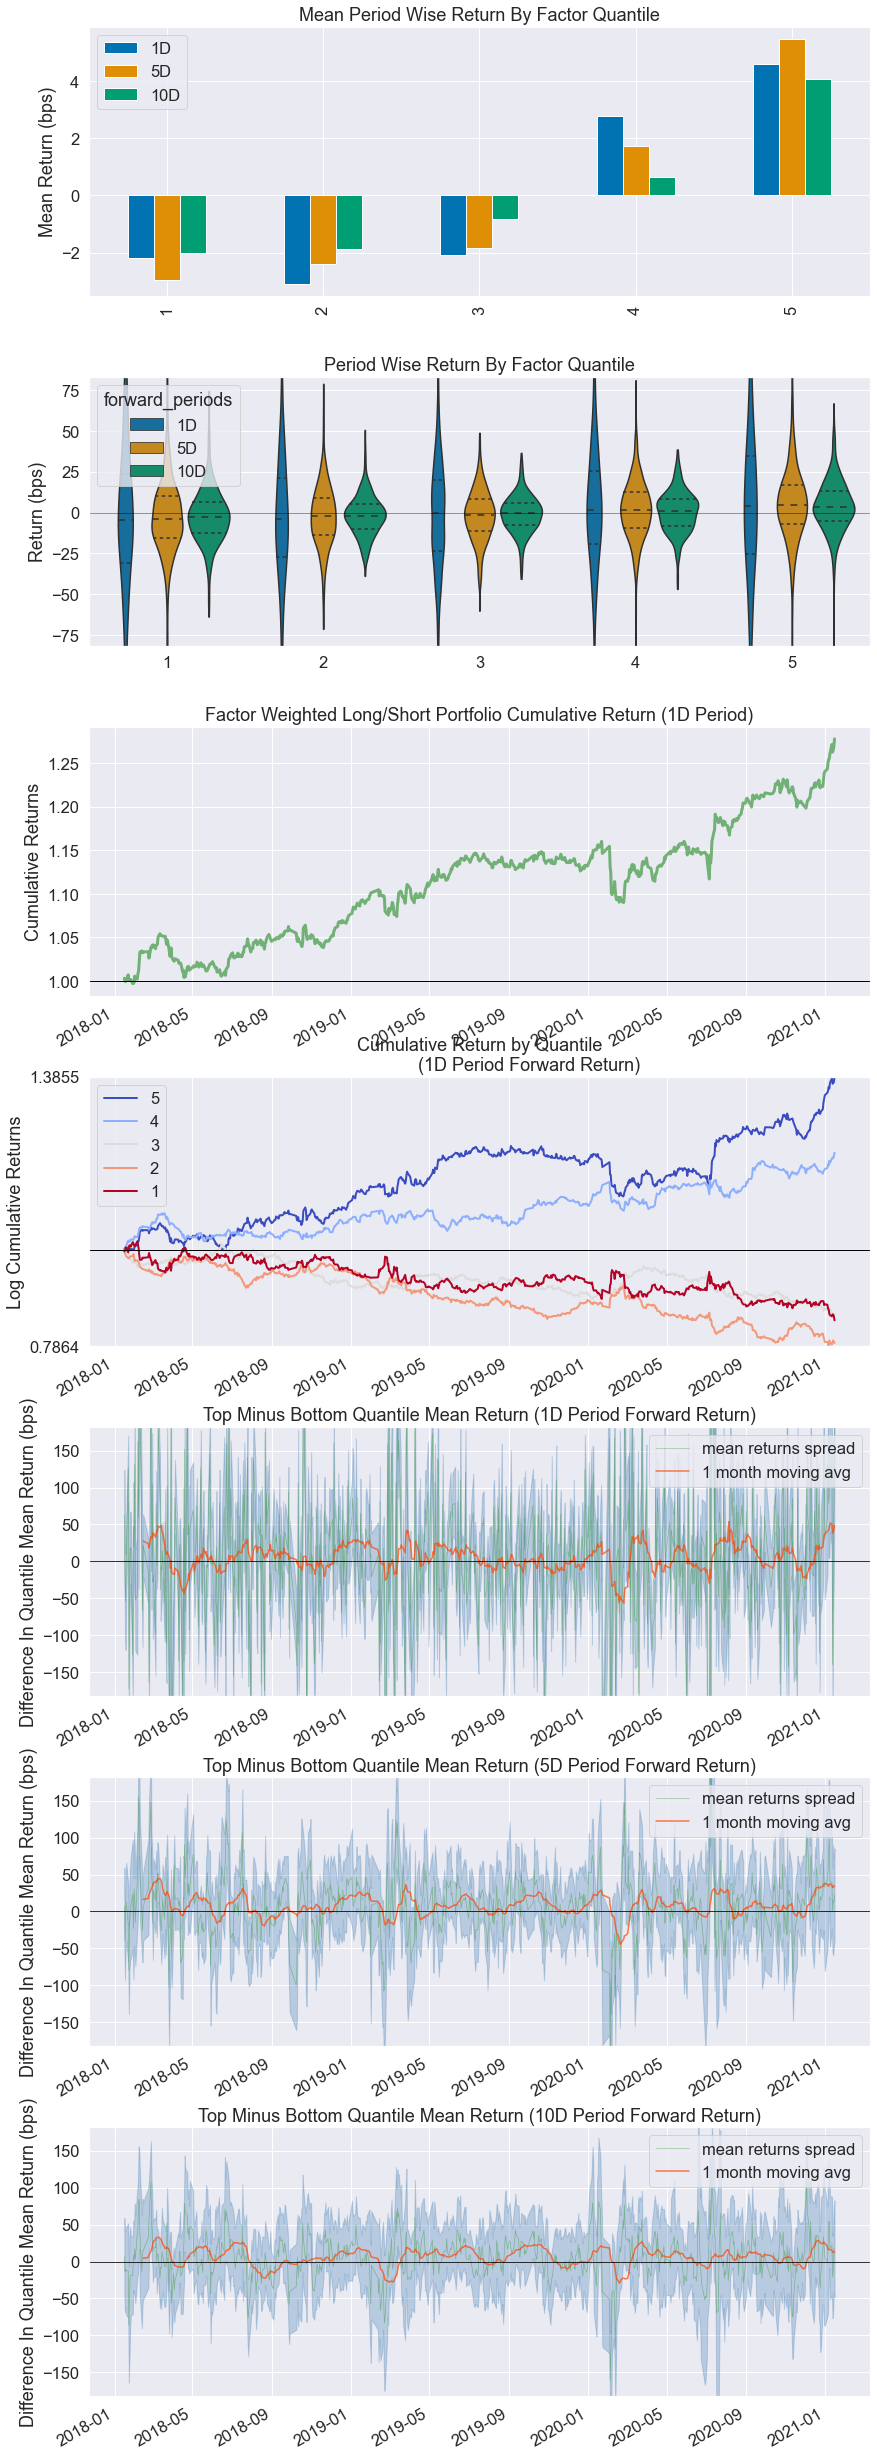

Information Analysis


,1D,5D,10D
IC Mean,0.015,0.036,0.043
IC Std.,0.130,0.131,0.132
Risk-Adjusted IC,0.114,0.273,0.323
t-stat(IC),3.086,7.381,8.722
p-value(IC),0.002,0.000,0.000
IC Skew,-0.003,-0.074,-0.372
IC Kurtosis,0.818,0.851,1.156


d:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

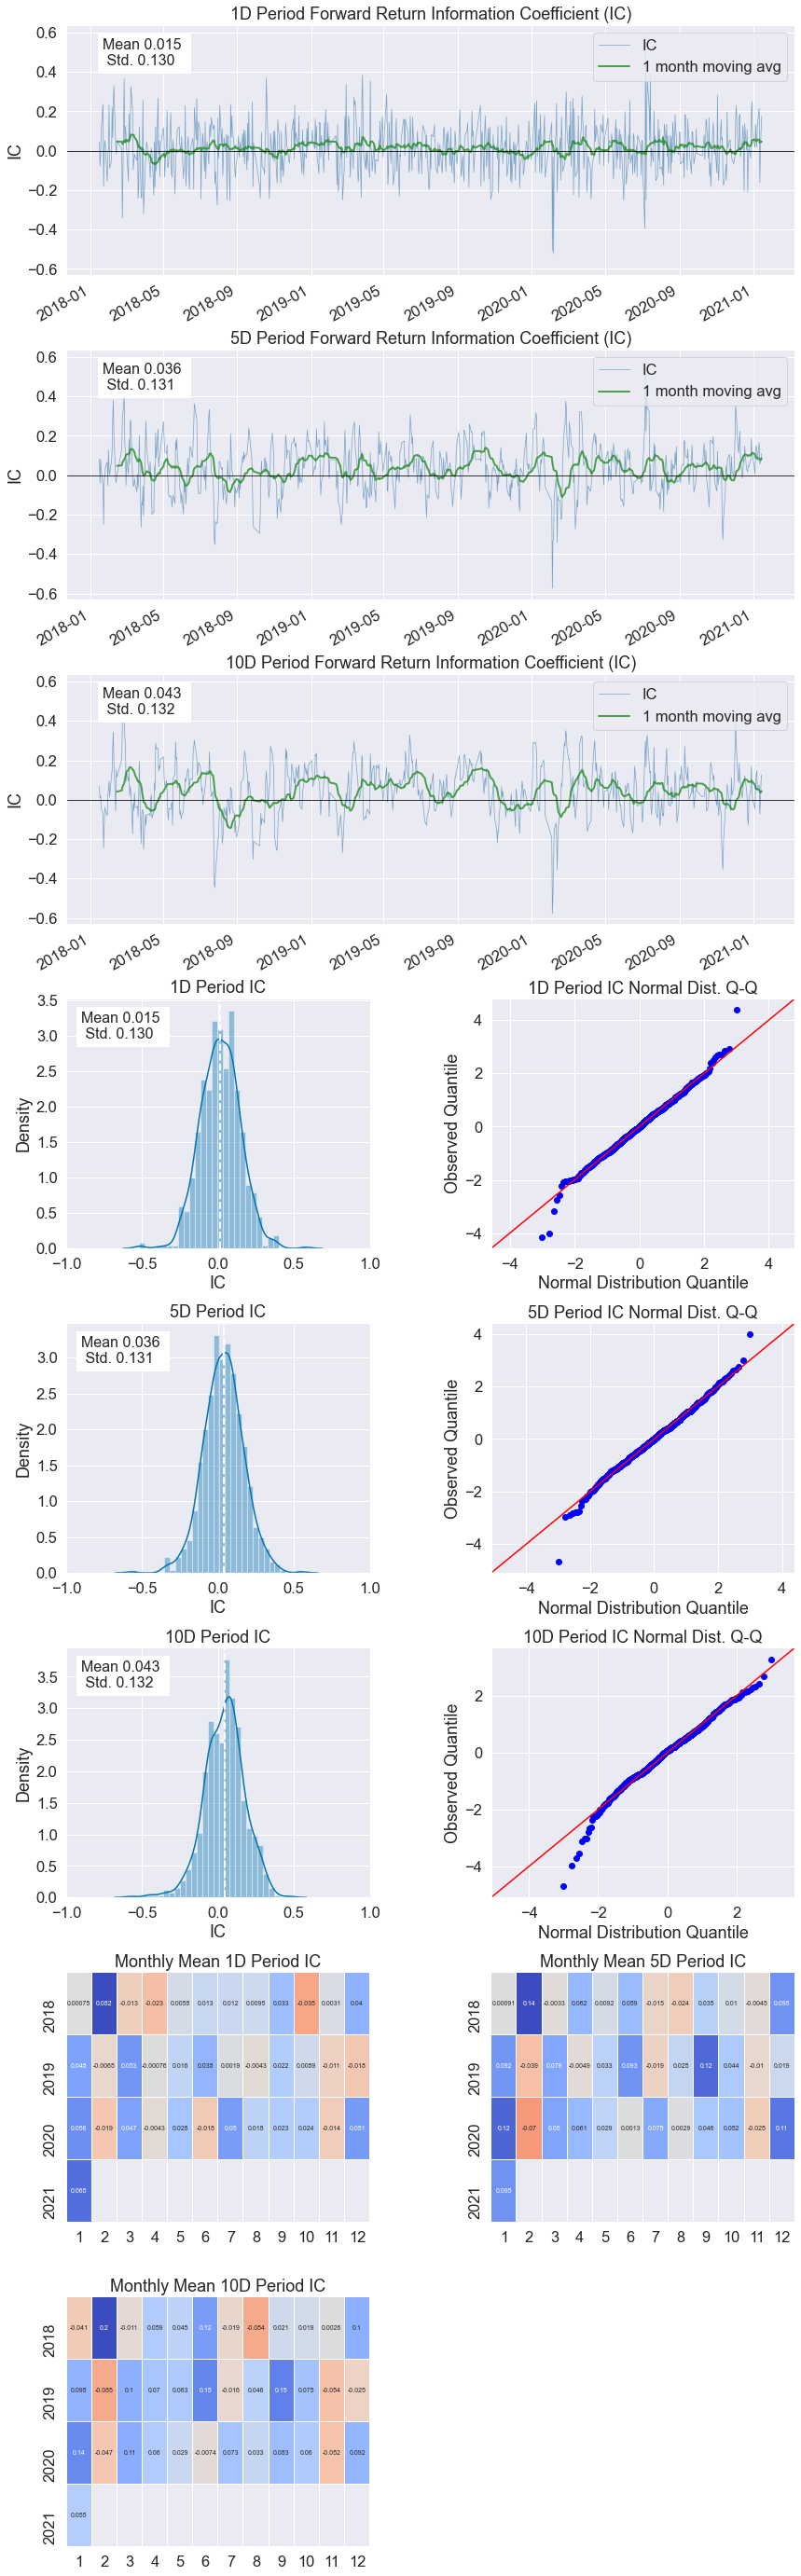

d:\anaconda\lib\site-packages\alphalens\utils.py:910: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.284,0.680,0.752
Quantile 2 Mean Turnover,0.522,0.778,0.793
Quantile 3 Mean Turnover,0.561,0.788,0.800
Quantile 4 Mean Turnover,0.524,0.775,0.794
Quantile 5 Mean Turnover,0.288,0.680,0.751


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.835,0.255,0.102


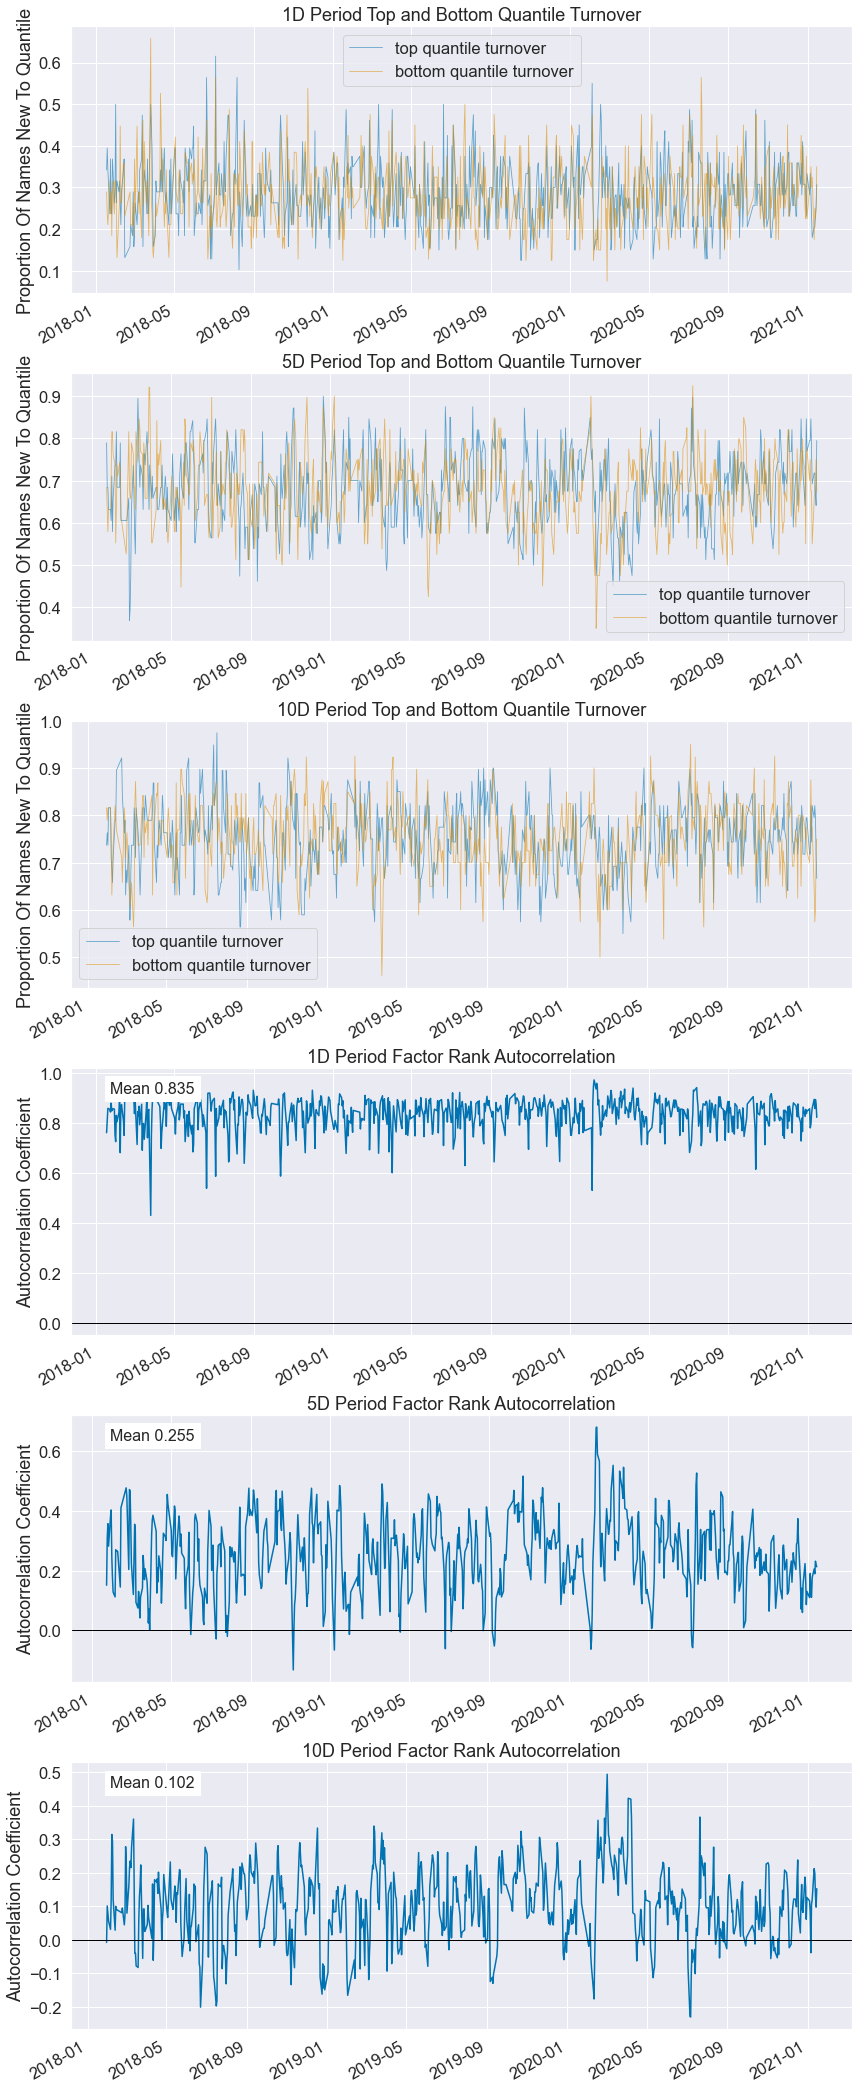

In [19]:
alphalens.tears.create_full_tear_sheet(ret)